* Formulate a hypothesis
* Design an experiment
* Collect the data
* Inference and conclusions

A/B Testing
* Hypothesis in mind and any observed difference is due to random chance in assignment or the true difference in the treatments.

Treatment
* Something to which a subject is exposed

Treatment group
* A group of subjects exposed to a treatment

Control group
* A group of subjects exposed to no treatment or the standard treatment

Randomization
* The process of randomly assigning subjects to treatments

Subjects
* the items that are being studied

Test statistic
* The metric used to measure the effect

Hypothesis test

Null hypothesis
* The hypothesis that there is no effect

Alternative hypothesis
* The hypothesis that there is an effect

One way test
* Hypothesis test that counts chance results only in one direction

Two-way test
* Hypothesis test that counts chance results in two directions

* Statistical hypothesis test is further analysis of an A/B test to asses whether the observed difference is statistically significant

The null hypotheses
* Require proof that the difference between groups is more extreme than the chance might reasonably produce

* Groups are equivalent and any difference between the groups is due to chance.

* The outcomes for groups A and B are different than the chance might produce.

Resampling permutation
* Shuffle the results from groups and then repeatedly deal out the data in the same group sizes as the original data.

* Observe how often we get difference as extreme as the observed difference.

Alternative hypothesis
* Offset alternative hypothesis

* Null "no difference between the means of group A dn group B"
* Alternative "there is a difference between the means of group A and group B"

One-way versus Two way hypothesis test

One way test
* You don't care about being fooled by chance in one direction, you will be sticking with A unless B is significantly better.

Two way test
* Protect you from being fooled by chance in either direction, the alternative hypothesis is that the means are different.

* The bootstrap is used to asses the reliability of an estimate and the permutation test is used to test the hypothesis between groups.

Permutation test
* Combining two or more samples together and randomly reallocating the observations to the groups.

Resampling
* Drawing additional samples form an observed dataset

With or without replacement
* Whether or not an item is returned to the population after it is drawn

Permutation test
* Change the order of a set of values
* Combine the results of two groups, they do not differ
* Randomly drawing groups from this combine set and seeing how much they differ

Process
* Combine the results from the different groups into a single data set
* Shuffle the combined data and then randomly draw without replacement a resample of the same size as group B
* Do the same for groups C, D, and so on
* You have collected a set of resamples that mirror the sizes of the original samples.
* Now calculate the estimate for the resamples and record it
* Repeat the previous step to yield a permutation distribution

* Go back to the observed difference between groups and compare it to the set of permuted differences, If the observed differences are extreme, then the null hypothesis is rejected and chance is not responsible for the difference and is statistically significant.

Proxy variable
* Stands in for the true variable of interest, which may be unavailable or difficult to measure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [2]:
data = pd.read_csv("/home/satire/PycharmProjects/Statistics/csv/AB_Test_Results.csv")

Cleaning the data

In [3]:
data.USER_ID.value_counts()

USER_ID
5652    6
9101    6
668     6
8359    6
4879    6
       ..
7165    1
8395    1
9168    1
2380    1
6174    1
Name: count, Length: 6324, dtype: int64

In [4]:
double_control = data[(data['USER_ID'].value_counts()>=2) & (data['VARIANT_NAME'] == 'control')]
double_variant = data[(data['USER_ID'].value_counts()>=2) & (data['VARIANT_NAME'] == 'variant')]
merged_id = pd.merge(double_control, double_variant, on='USER_ID')
print(f"not null revenue x: {len(merged_id[merged_id['REVENUE_x']>0])}")
print(f"not null revenue y: {len(merged_id['REVENUE_y']>0)}")
merged_id.shape

not null revenue x: 3
not null revenue y: 179


/tmp/ipykernel_27737/332722917.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  double_control = data[(data['USER_ID'].value_counts()>=2) & (data['VARIANT_NAME'] == 'control')]
/tmp/ipykernel_27737/332722917.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  double_variant = data[(data['USER_ID'].value_counts()>=2) & (data['VARIANT_NAME'] == 'variant')]


(179, 5)

In [5]:
# The operator ~ check whether a value is present in the list, identifying values that are missing from the merge_id dataframe
df_not_null = data[~data['USER_ID'].isin(merged_id.USER_ID)]
print(f"After: {data.shape[0]}, before: {df_not_null.shape[0]}")

After: 10000, before: 9555


In [6]:
df_not_null.shape

(9555, 3)

In [7]:
df_not_null.sample(10)

,USER_ID,VARIANT_NAME,REVENUE
4926,4535,variant,0.0
1556,4293,control,0.0
8740,9945,control,0.0
4535,6238,variant,0.0
809,2744,variant,0.0
1390,9486,control,0.0
5834,3815,control,0.0
3040,8175,control,0.0
9496,866,control,0.0
4831,9448,variant,0.0


Text(0.5, 0.98, '')

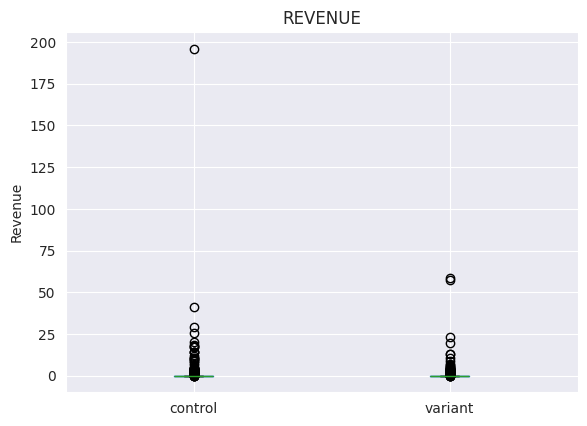

In [8]:
ax = df_not_null.boxplot(by="VARIANT_NAME", column='REVENUE')
ax.set_xlabel('')
ax.set_ylabel('Revenue')
plt.suptitle('')

In [9]:
mean_control = df_not_null[df_not_null['VARIANT_NAME'] == "control"].REVENUE.mean()
mean_variant = df_not_null[df_not_null['VARIANT_NAME'] == "variant"].REVENUE.mean()
mean_control - mean_variant

np.float64(0.059225257458739175)

* Now it needs to be questioned whether this difference is within range of what random chance might produce is statically significant.

Permutation test
* Combine all the revenue values together and then repeatedly shuffle and divide them into groups

* Sampling without replacement number of elements of control group and the remaining indices are assigned to variant group. The difference between the two means is returned, calling this function R times = 1,000 times leading to a distribution of differences can be plotted as a histogram

In [10]:
def perm_func(x, n_control, n_variant):
    n = n_control + n_variant
    idx_variant = list(random.sample(range(n), n_variant))
    idx_control = list(set(range(n)) - set(idx_variant))
    return x.loc[idx_control].mean() - x.loc[idx_variant].mean()

Text(0, 0.5, 'Frequency')

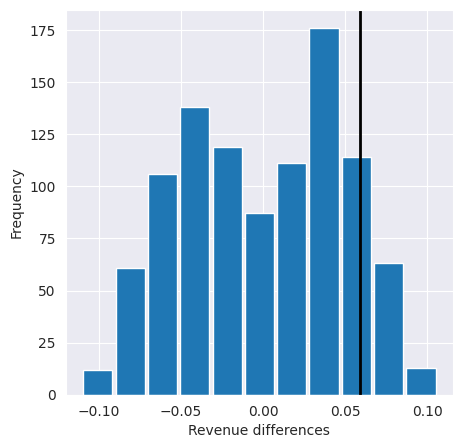

In [11]:
n_control = len(df_not_null[df_not_null['VARIANT_NAME'] == "control"])
n_variant = len(df_not_null[df_not_null['VARIANT_NAME'] == "variant"])

perm_diffs = [perm_func(data.REVENUE, n_control, n_variant) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_control - mean_variant, color='black', lw=2)
ax.set_xlabel('Revenue differences')
ax.set_ylabel('Frequency')

This histogram shows that mean difference of random permutations often exceeds the observed difference in revenues between the control and variant groups.

In [12]:
np.mean(perm_diffs > mean_control - mean_variant)

np.float64(0.111)

This happens 0.117 times out of 1,000, which is not statistically significant.

This suggest that the observed difference in revenue is well within range and is not statistically significant.

Variations of permutation tests
* Bootstrap
* Exhaustive permutation test

Exhaustive permutation test
* Figuring out all the possible ways it could be divided into groups, only for small sample sizes

Bootstrap
* Made with replacement instead of without replacement, Not just the random element in the assignment of treatment to subject but also the random element in the selection of subjects from a population.